In [21]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr

In [6]:
COUNTS_PATH = "../process_geuvadis_data/log_tpm/corrected_log_tpm.annot.csv.gz"
GENE_CLASS_PATH = "../finetuning/data/h5_bins_384_chrom_split/gene_class.csv"

In [7]:
counts_df = pd.read_csv(COUNTS_PATH, index_col="our_gene_name")

class_df = pd.read_csv(GENE_CLASS_PATH, index_col=0)
random_split_genes = class_df[class_df["class"] == "random_split"].index.tolist()
population_split_genes = class_df[class_df["class"] == "yri_split"].index.tolist()

# Overall metrics

In [8]:
PREDS_384_BINS_PATH = "h5_bins_384_chrom_split/384_bins_no_cv/preds.csv"
PREDS_1MB_PATH = "h5_bins_384_chrom_split/1Mb_no_cv/preds.csv"

In [10]:
def compute_mean_pearson(
    preds_df: pd.DataFrame, counts_df: pd.DataFrame, genes: list
) -> float:
    corrs = []
    for gene in genes:
        preds = preds_df.loc[gene].dropna()
        counts = counts_df.loc[gene, preds.index]
        assert len(preds) == len(counts) == 77
        corr, _ = pearsonr(preds, counts)
        corr = np.nan_to_num(corr)
        corrs.append(corr)
    return np.mean(corrs)

In [12]:
preds_384_bins_df = pd.read_csv(PREDS_384_BINS_PATH, index_col=0)
preds_1Mb_df = pd.read_csv(PREDS_1MB_PATH, index_col=0)

print("Random split performance")
print("------------------------")
print(
    "384 bins context size: ",
    compute_mean_pearson(preds_384_bins_df, counts_df, random_split_genes),
)
print(
    "1Mb context size: ",
    compute_mean_pearson(preds_1Mb_df, counts_df, random_split_genes),
)
print("")

print("Population split performance")
print("----------------------------")
print(
    "384 bins context size: ",
    compute_mean_pearson(preds_384_bins_df, counts_df, population_split_genes),
)
print(
    "1Mb context size: ",
    compute_mean_pearson(preds_1Mb_df, counts_df, population_split_genes),
)

Random split performance
------------------------
384 bins context size:  0.27017093395111663
1Mb context size:  0.26329726271765685

Population split performance
----------------------------


/tmp/ipykernel_908403/2810210140.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)


384 bins context size:  0.13937764361090668
1Mb context size:  0.1355394341862095


# Scaling experiments

In [15]:
SCALING_DIR = "h5_bins_384_chrom_split_scaling_expts"
SCALING_384_BINS_DIR = os.path.join(SCALING_DIR, "384_bins_no_cv")
SCALING_1MB_DIR = os.path.join(SCALING_DIR, "1Mb_no_cv")

In [18]:
def compute_mean_pearson_scaling(
    preds_dir: str,
    counts_df: pd.DataFrame,
    genes: list,
    subsets: list = [0.2, 0.4, 0.6, 0.8, 1.0],
    n_replicates: int = 3,
):
    pearsons = np.full((len(subsets), n_replicates), np.nan)
    for i, subset in enumerate(subsets):
        for j in range(n_replicates):
            fname = f"subset_fraction_{subset}_replicate_{j + 1}.csv"
            preds_df = pd.read_csv(os.path.join(preds_dir, fname), index_col=0)
            pearsons[i, j] = compute_mean_pearson(preds_df, counts_df, genes)
    return pearsons

In [20]:
random_split_384_bins_scaling_pearsons = compute_mean_pearson_scaling(
    SCALING_384_BINS_DIR, counts_df, random_split_genes
)
random_split_1Mb_scaling_pearsons = compute_mean_pearson_scaling(
    SCALING_1MB_DIR, counts_df, random_split_genes
)

population_split_384_bins_scaling_pearsons = compute_mean_pearson_scaling(
    SCALING_384_BINS_DIR, counts_df, population_split_genes
)
population_split_1Mb_scaling_pearsons = compute_mean_pearson_scaling(
    SCALING_1MB_DIR, counts_df, population_split_genes
)

/tmp/ipykernel_908403/2810210140.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_908403/2810210140.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_908403/2810210140.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_908403/2810210140.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_908403/2810210140.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_908403/2810210140.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(p

In [104]:
def plot_scaling_results(
    random_split_pearsons: np.ndarray,
    population_split_pearsons: np.ndarray,
    ax: plt.Axes,
    subsets: list = [0.2, 0.4, 0.6, 0.8, 1.0],
):
    """Add data to dataframe first. DataFrame should contain columns:
    - Split type (random or population)
    - Subset fraction
    - Replicate number
    - Pearson correlation
    """
    rep_names = [f"replicate_{i + 1}" for i in range(random_split_pearsons.shape[1])]

    random_split_df = pd.DataFrame(random_split_pearsons, columns=rep_names)
    random_split_df["subset_fraction"] = subsets
    random_split_df = random_split_df.melt(
        id_vars="subset_fraction", var_name="replicate", value_name="pearson"
    )
    random_split_df["split"] = "Random split"

    pop_split_df = pd.DataFrame(population_split_pearsons, columns=rep_names)
    pop_split_df["subset_fraction"] = subsets
    pop_split_df = pop_split_df.melt(
        id_vars="subset_fraction", var_name="replicate", value_name="pearson"
    )
    pop_split_df["split"] = "Population split"

    df = pd.concat([random_split_df, pop_split_df], axis=0)
    df["subset_percentage"] = (df["subset_fraction"] * 100).astype(int)

    sns.lineplot(
        data=df,
        x="subset_percentage",
        y="pearson",
        hue="split",
        style="split",
        errorbar="sd",
        markers=True,
        dashes=False,
        ax=ax,
    )

    # Add mean +- std text underneath each line
    for split in df["split"].unique():
        for pct in df["subset_percentage"].unique():
            subset_df = df[(df["split"] == split) & (df["subset_percentage"] == pct)]
            mean = subset_df["pearson"].mean()
            std = subset_df["pearson"].std()
            text = rf"{mean:.3f} $\pm$" + "\n" + f"{std:.3f}"
            ax.text(pct, mean - std - 0.01, text, ha="center", va="center", fontsize=7)

    ax.set_ylim(0.05)
    ax.set_xlabel("Fraction of training set samples used")
    ax.set_ylabel("Pearson correlation")
    ax.legend(frameon=False, loc="upper left")

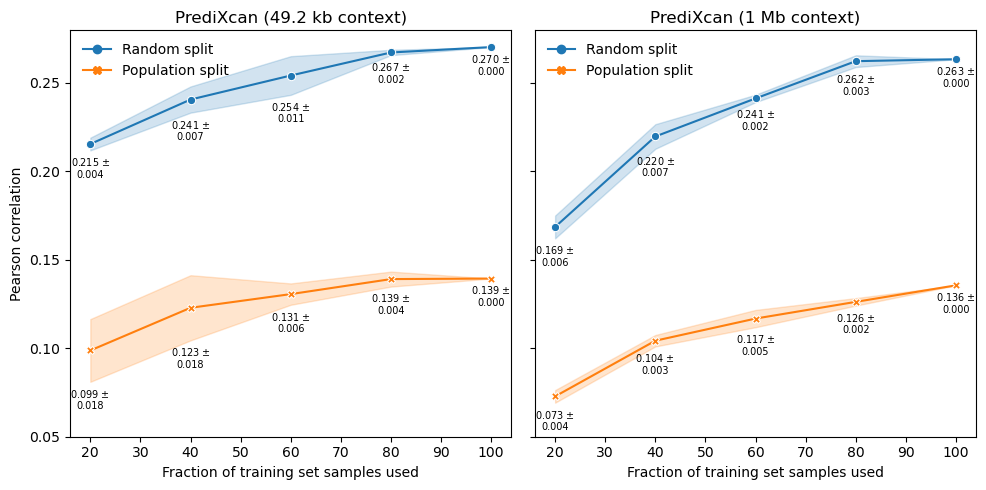

In [109]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))

plot_scaling_results(
    random_split_384_bins_scaling_pearsons,
    population_split_384_bins_scaling_pearsons,
    axs[0],
)
axs[0].set_title("PrediXcan (49.2 kb context)")

plot_scaling_results(
    random_split_1Mb_scaling_pearsons, population_split_1Mb_scaling_pearsons, axs[1]
)
axs[1].set_title("PrediXcan (1 Mb context)")

plt.tight_layout()
plt.show()